In [1]:
import pandas as pd

writer_dir_name = 'data/geolife/runs'
log_dir_name = '[time-hetnet_single]_20240324-102845'
log_folder = writer_dir_name + '/' + log_dir_name
best_model_path = log_folder + '/best_model.pth'

config_df = pd.read_csv(log_folder + '/configuration.csv')
config_df.head()

,device,user_list_type,model_type,args_dims,round_min,round_sec,day,day_divide,length,y_timestep,...,sample_q,epoch,patience,x_attribute,file_mode,time_delta,train_list,val_list,test_list,train_columns
0,cuda:0,single,time-hetnet,"[32, 32, 32]",60,10,24,12,168,6,...,3,10000000,1000000,9,min,20,['003'],['003'],['003'],"['year', 'month', 'week', 'hour', 'day', 'time..."


In [2]:
model_type = config_df['model_type'][0]

data_dir = "data/geolife/Data/"
label_attribute = 2

sample_s = config_df['sample_s'][0]
sample_q = config_df['sample_q'][0]

args_epoch = config_df['epoch'][0]
args_patience = config_df['patience'][0]

gap_min = 12 # 1 min
gap = gap_min

hidden_layer = config_df['hidden_layer'][0]
cell = 256#config_df['cell'][0]

loss_method = 'mse'
# loss_method = 'cross'

user_list_type = config_df['user_list_type'][0]

day = config_df['day'][0]
day_divide = config_df['day_divide'][0]
# week = config_df['week'][0]
x_attribute = config_df['x_attribute'][0]
y_timestep = config_df['y_timestep'][0] 
length = config_df['length'][0]

file_mode = config_df['file_mode'][0]
round_min = config_df['round_min'][0]
round_sec = config_df['round_sec'][0] # (seconds) per 10s
time_delta = 20 # (minutes) 1 segment length

train_list = config_df['train_list'][0]
validation_list = config_df['val_list'][0]
test_list = config_df['test_list'][0]

train_size = 0.4
validation_size = 0.1
batch_size = config_df['batch_size'][0] # each user
batch_size = 3

device = "cpu" #config_df['device'][0]

## Test Phase
is_train = False

print(f"day:{day}, y_timestep:{y_timestep}, length:{length}, model_type:{model_type}")
print(f"train_columns: {config_df['train_columns'][0]}")

day:24, y_timestep:6, length:168, model_type:time-hetnet
train_columns: ['year', 'month', 'week', 'hour', 'day', 'time_grid', 'mask', 'x', 'y']


In [ ]:
# TensorBoard 설정
import torch
from torch.utils.data import DataLoader

from torch_mlp import MLP
from torch_mlp_dataset import MlpDataset

data_dir = "data/geolife/Data/"

train_list = config_df['train_list'][0]
validation_list = config_df['val_list'][0]
test_list = config_df['val_list'][0]#, '078']

test_list = ['035']

print(f"train_list:      {train_list}")
print(f"validation_list: {validation_list}")
print(f"test_list:       {test_list}")

test_data         = MlpDataset(data_dir, test_list, y_timestep, day, round_min, round_sec, time_delta, label_attribute, length, device, file_mode)
test_dataloader   = DataLoader(test_data, batch_size, shuffle=False)
        
best_model = MLP(input_shape=[length, x_attribute], y_timestep = y_timestep, loss_fn=loss_method, label_attribute=label_attribute, cell=cell, hidden_layer=hidden_layer)

best_model.load_state_dict(torch.load(best_model_path, map_location=torch.device('cpu')))

In [ ]:
# MLP graph
# https://jimmy-ai.tistory.com/30
import matplotlib.pyplot as plt
import numpy as np

def metricMenhattan(y_true, y_pred):
    row = torch.abs(y_pred[:,:,:,0] - y_true[:,:,:,0])
    col = torch.abs(y_pred[:,:,:,1] - y_true[:,:,:,1])
    return row + col

def mlp_metricMenhattan(y_true, y_pred):
    row = torch.abs(y_pred[:,:,0] - y_true[:,:,0])
    col = torch.abs(y_pred[:,:,1] - y_true[:,:,1])
    return row + col

def metricEuclidean(y_true, y_pred):
    row = (y_pred[:,:,0] - y_true[:,:,0])**2
    col = (y_pred[:,:,1] - y_true[:,:,1])**2
    return (row + col)** 0.5

with torch.no_grad():
    MASK = 0
    X = 1
    Y = 2
    time = np.arange(y_timestep)
    zero_line = np.zeros(y_timestep)
    print(f"time len: {len(time)}")
    print(f"test_dataloader: {len(test_dataloader.dataset)}")
    for idx, test_data in enumerate(test_dataloader, 0):
        test_X, test_y = test_data
        test_y_mask = (test_y[:, :, MASK] == 1)

        # mlp
        output = best_model(test_X)
        output = torch.concat([torch.unsqueeze(test_y[:,:,MASK], -1), output], axis=-1)

        criterion = metricEuclidean
        loss = criterion(test_y, output)

        if idx % 5 != 1:
            continue

        padding = 500
        for batch_id in range(test_y.shape[0]-1):
            if test_y[batch_id, test_y_mask[batch_id], X].shape[0] <= 0:
                break

            plt.figure(figsize=(10, 8))
            # 3row, 1col
            plt.subplot(3, 1, 1)

            plt.title('X graph')
            ymax, _ = torch.max(test_y[batch_id, test_y_mask[batch_id], X], dim=-1)
            ymin, _ = torch.min(test_y[batch_id, test_y_mask[batch_id], X], dim=-1)
            plt.ylim(ymin - padding, ymax + padding)
            # plt.axis([xmin, xmax, ymin, ymax])
            plt.plot(time, output[batch_id, :, X] , color='r', alpha=0.3)
            plt.scatter(time[test_y_mask[batch_id]], output[batch_id, test_y_mask[batch_id], X], color='r', alpha = 0.5)
            plt.scatter(time[test_y_mask[batch_id]], test_y[batch_id, test_y_mask[batch_id], X], color='b', alpha = 0.5)
            plt.xlabel('time (hour)')
            plt.ylabel('X (m)')

            plt.subplot(3, 1, 2)
            plt.title('Y graph')
            ymax = test_y[batch_id, test_y_mask[batch_id], Y].max()
            ymin = test_y[batch_id, test_y_mask[batch_id], Y].min()
            plt.ylim(ymin - padding, ymax + padding)
            plt.plot(time, output[batch_id, :, Y] , color='r', alpha=0.3)
            plt.scatter(time[test_y_mask[batch_id]], output[batch_id, test_y_mask[batch_id], Y], color='r', alpha = 0.5)
            plt.scatter(time[test_y_mask[batch_id]], test_y[batch_id, test_y_mask[batch_id], Y], color='b', alpha = 0.5)
            plt.xlabel('time (hour)')
            plt.ylabel('Y (m)')

            plt.subplot(3, 1, 3)
            plt.title('Euclidean (m)')
            plt.ylim(0, 100)
            plt.plot(time, zero_line, color='b', alpha=0.1)
            plt.scatter(time[test_y_mask[batch_id]], loss[batch_id, test_y_mask[batch_id]], color='r', alpha = 0.5)
            plt.xlabel('time (per hour)')
            plt.ylabel('Loss')

            plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.5)

train_list:      ['003']
validation_list: ['003']
test_list:       ['003']
tensor(29717309.5135, dtype=torch.float64)
tensor(30287256.7724, dtype=torch.float64)


IndexError: max(): Expected reduction dim 0 to have non-zero size.

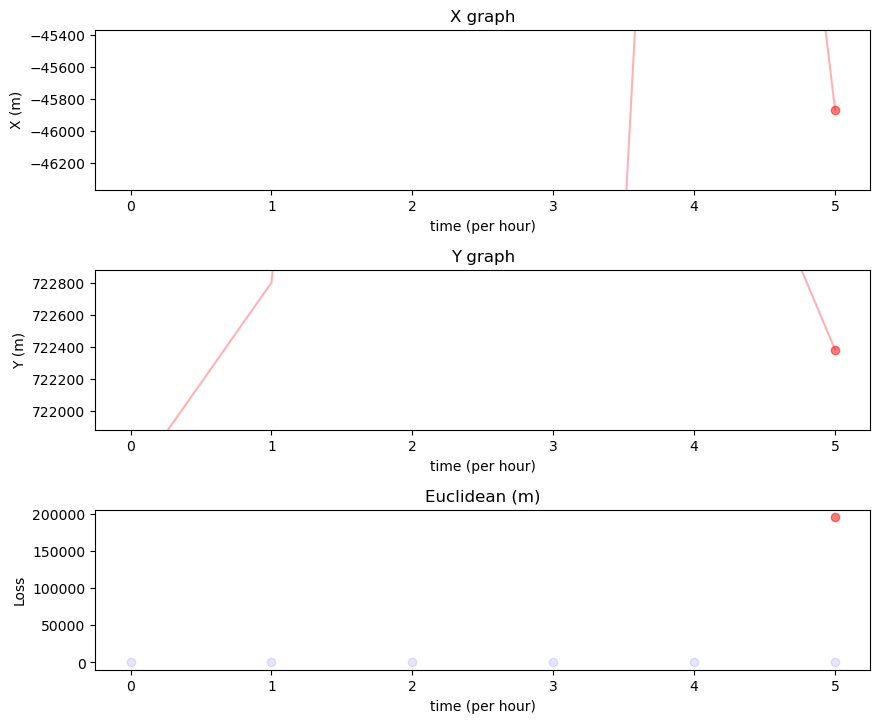

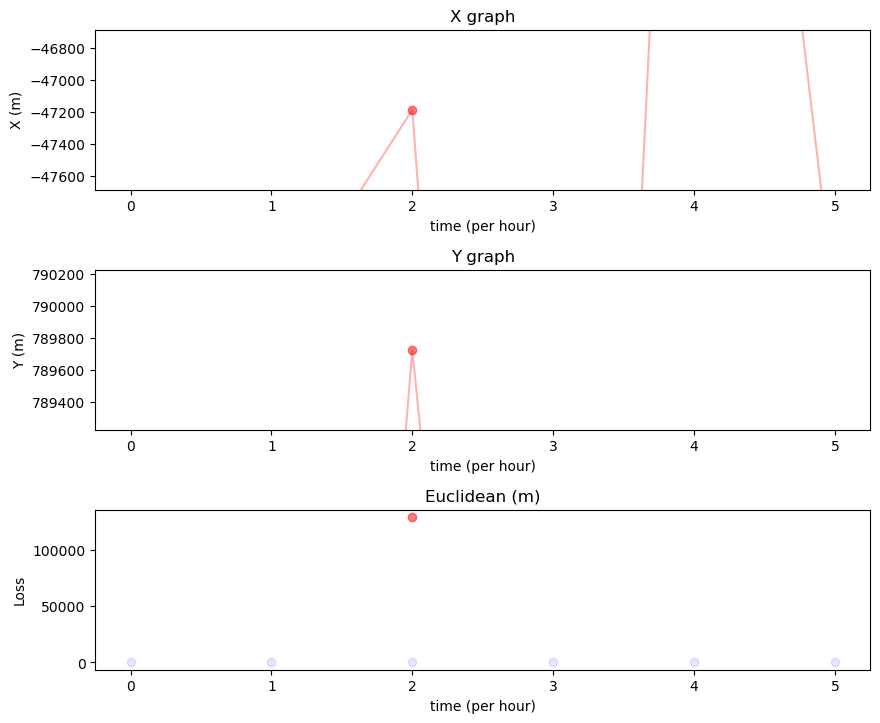

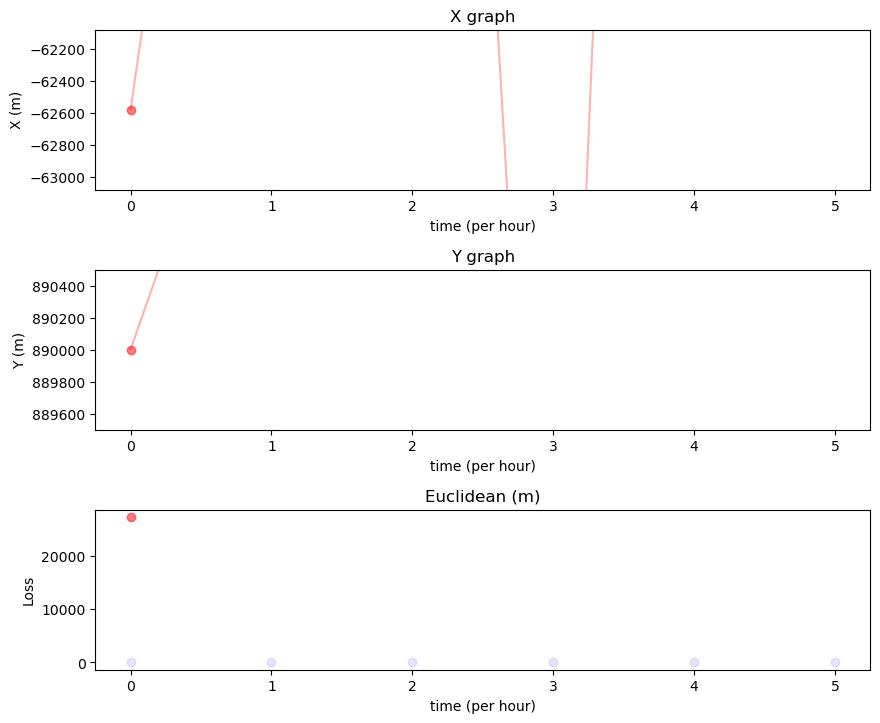

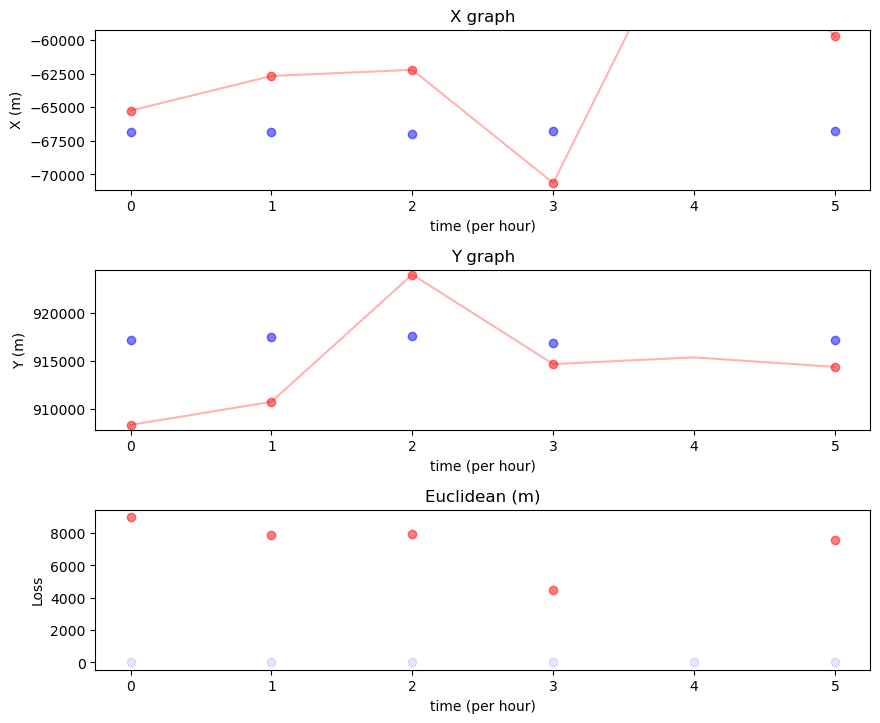

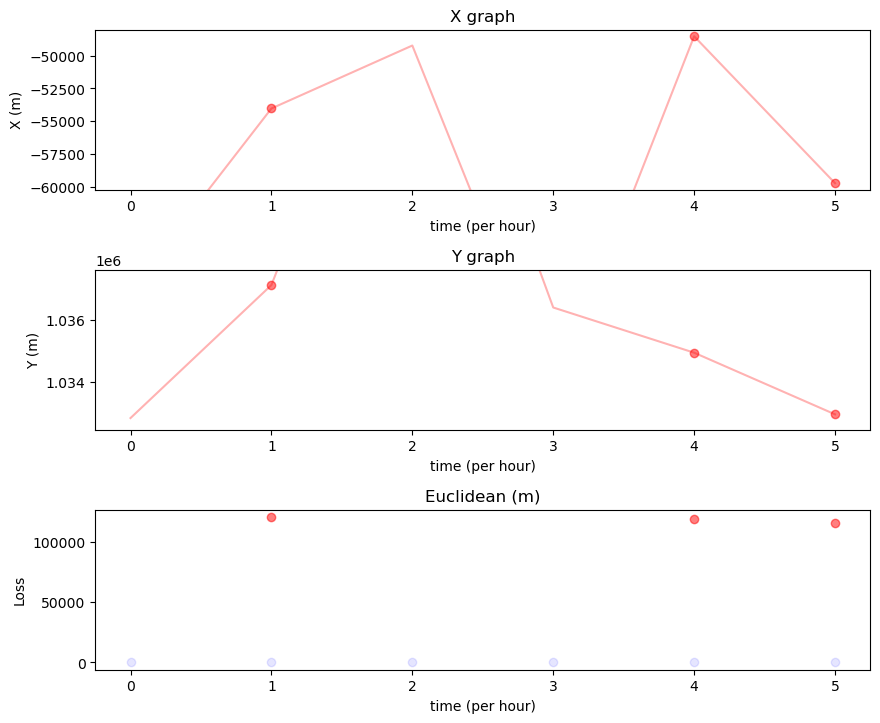

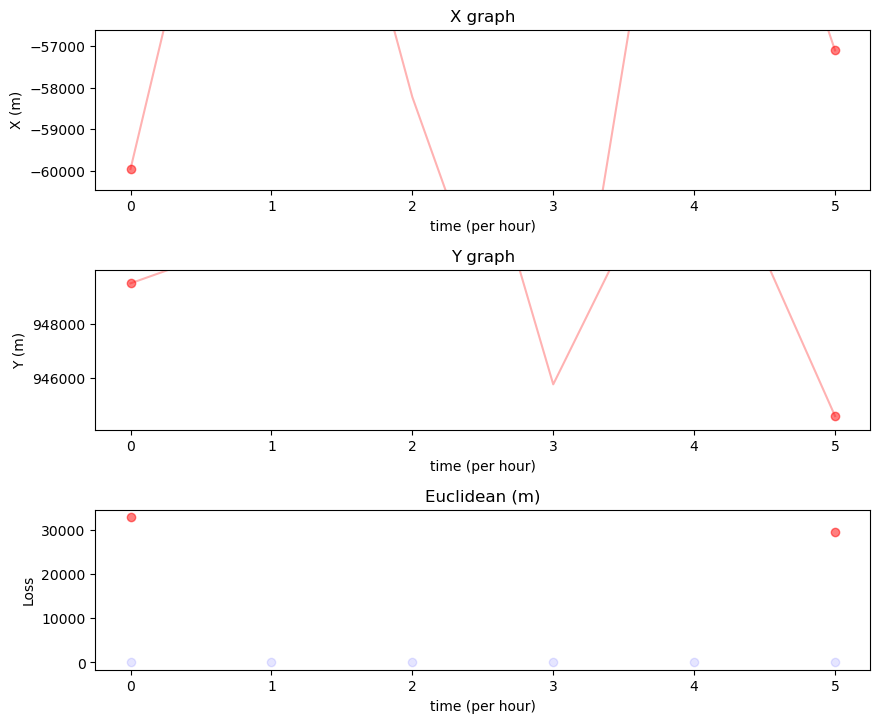

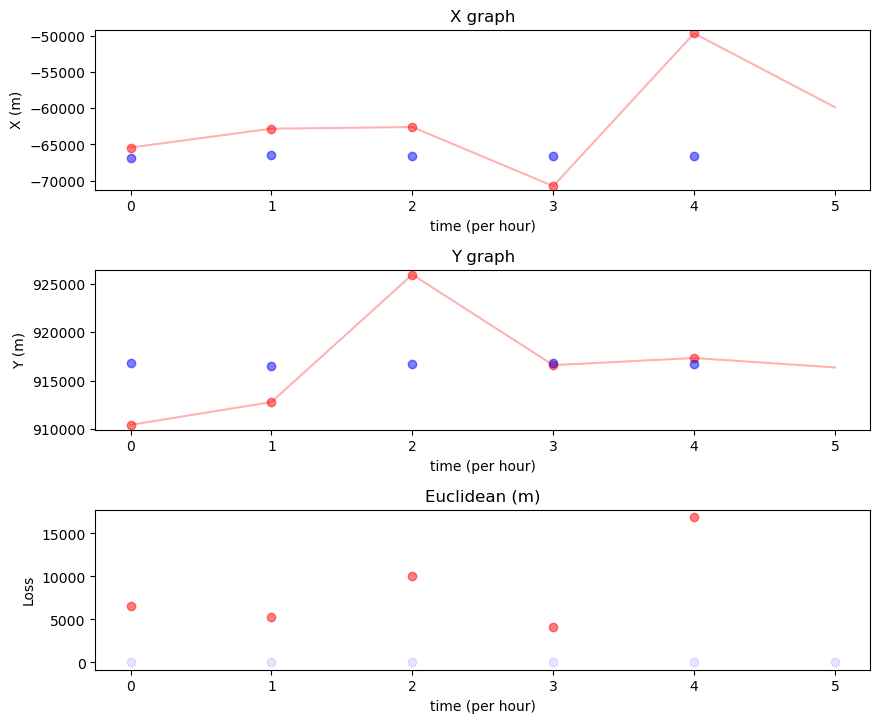

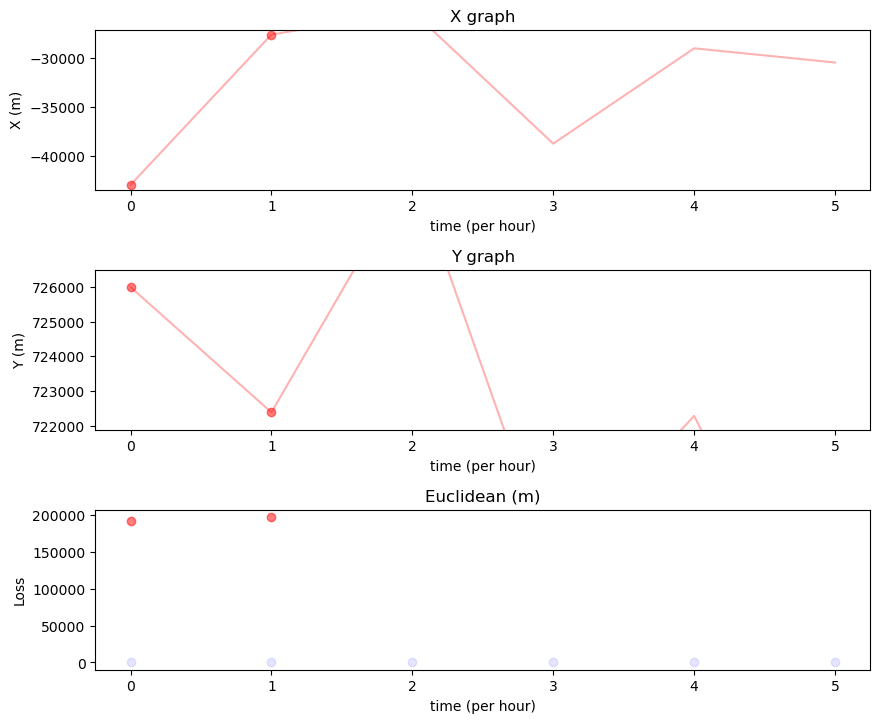

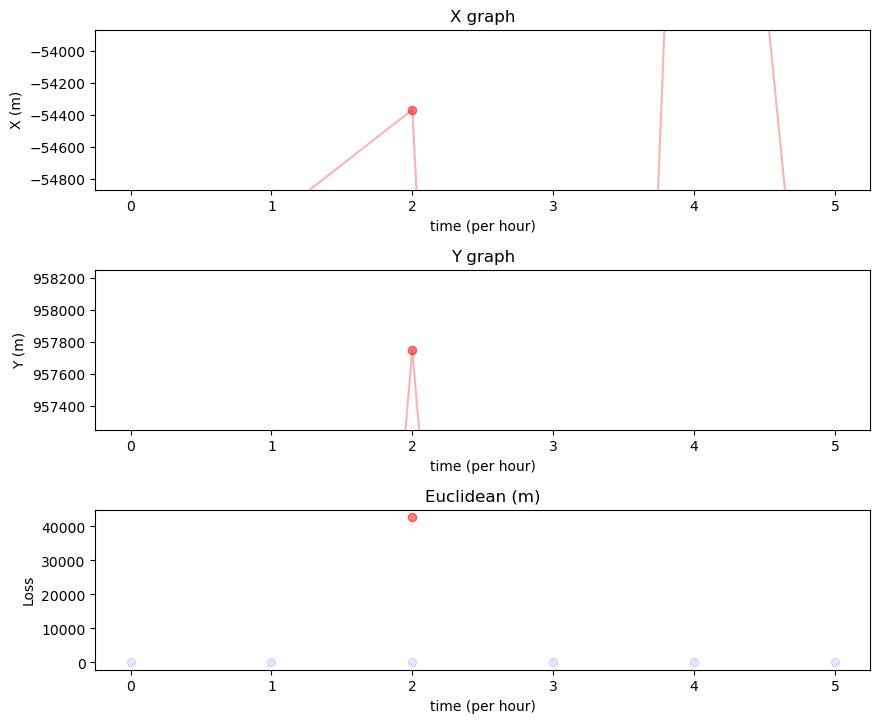

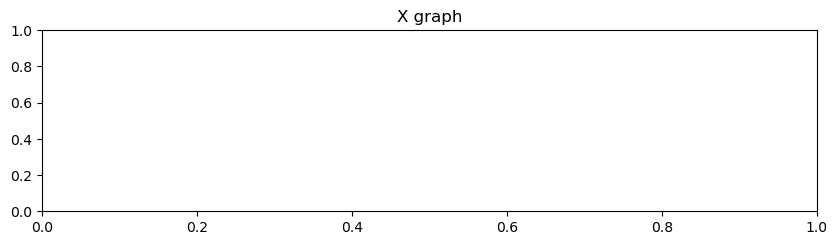

In [10]:
# Time-hetnet graph
# https://jimmy-ai.tistory.com/30

# TensorBoard 설정
import ast
from torch_time_het import TimeHetNet

import torch
from torch.utils.data import DataLoader

from torch_segment_dataset import SegmentDataset

data_dir = "data/geolife/Data/"


train_list = config_df['train_list'][0]
validation_list = config_df['val_list'][0]
test_list = config_df['val_list'][0]#, '078']

test_list = ['003']

print(f"train_list:      {train_list}")
print(f"validation_list: {validation_list}")
print(f"test_list:       {test_list}")

test_data               = SegmentDataset('test', user_list_type, data_dir, test_list, device, day, day_divide, round_min, round_sec, time_delta, y_timestep, length, label_attribute, sample_s, sample_q, file_mode)
test_dataloader         = DataLoader(test_data, batch_size, shuffle=False)    
    
best_model = TimeHetNet(dims_inf = ast.literal_eval("[32,32,32]"),
                    dims_pred = ast.literal_eval("[32,32,32]"), 
                    activation="relu", 
                    time=100,
                    batchnorm=False, 
                    block = str("gru,conv,conv,gru").split(","),
                    output_shape=[y_timestep, 2],
                    length=length)

best_model.load_state_dict(torch.load(best_model_path, map_location=torch.device('cpu')))

import matplotlib.pyplot as plt
import numpy as np

def metricMenhattan(y_true, y_pred):
    row = torch.abs(y_pred[:,:,:,0] - y_true[:,:,:,0])
    col = torch.abs(y_pred[:,:,:,1] - y_true[:,:,:,1])
    return row + col

def metricEuclidean(y_true, y_pred):
    row = (y_pred[:,:,:,1] - y_true[:,:,:,1])**2
    col = (y_pred[:,:,:,2] - y_true[:,:,:,2])**2
    result = (row+col)**0.5
    return result

with torch.no_grad():
    # MASK = 0
    X = 1
    Y = 2
    time = np.arange(y_timestep)
    zero_line = np.zeros(y_timestep)

    for idx, test_data in enumerate(test_dataloader, 0):
        test_X, test_y = test_data
        
        output = best_model(test_X)
        
        mask, y_true = test_y
        output = torch.cat([mask[:, :, :].unsqueeze(-1), output], axis=-1)
        y_true = torch.cat([mask[:, :, :].unsqueeze(-1), y_true], axis=-1)

        loss = metricEuclidean(y_true, output)
        print(torch.sum(loss))
        test_loss = torch.unsqueeze(loss, -1)

        # if idx % 10 != 1:
        #     continue

        # print(f"y_true shape: {y_true.shape}")
        padding = 500
        for batch_idx in range(y_true.shape[0]):
            # if batch_idx != 0:
            #     continue
            for query_idx in range(y_true.shape[1]):
                plt.figure(figsize=(10, 8))

                plt.subplot(3, 1, 1)
                plt.title('X graph')
                
                test_y_mask = (output[batch_idx, query_idx, :, 0] > 0.5)
                # if test_y_mask.sum() == 0:
                #     continue
                ymax, _ = torch.max(output[batch_idx, query_idx, test_y_mask, X], dim=-1)
                ymin, _ = torch.min(output[batch_idx, query_idx, test_y_mask, X], dim=-1)

                plt.ylim(ymin - padding, ymax + padding)
                plt.plot(time, output[batch_idx, query_idx, :, X] , color='r', alpha=0.3)
                plt.scatter(time[test_y_mask], output[batch_idx, query_idx, test_y_mask, X], color='r', alpha = 0.5)
                plt.scatter(time[test_y_mask], y_true[batch_idx, query_idx, test_y_mask, X], color='b', alpha = 0.5)
                plt.xlabel('time (per hour)')
                plt.ylabel('X (m)')
                
                ## y
                plt.subplot(3, 1, 2)
                plt.title('Y graph')
                
                test_y_mask = (output[batch_idx, query_idx, :, 0] > 0.5)
                ymax, _ = torch.max(output[batch_idx, query_idx, test_y_mask, Y], dim=-1)
                ymin, _ = torch.min(output[batch_idx, query_idx, test_y_mask, Y], dim=-1)

                plt.ylim(int(ymin - padding), int(ymax + padding))
                plt.plot(time, output[batch_idx, query_idx, :, Y] , color='r', alpha=0.3)
                plt.scatter(time[test_y_mask], output[batch_idx, query_idx, test_y_mask, Y], color='r', alpha = 0.5)
                plt.scatter(time[test_y_mask], y_true[batch_idx, query_idx, test_y_mask, Y], color='b', alpha = 0.5)
                plt.xlabel('time (per hour)')
                plt.ylabel('Y (m)')
                
                plt.subplot(3, 1, 3)
                plt.title('Euclidean (m)')
                # plt.ylim(0, 100)
                plt.scatter(time, zero_line, color='b', alpha=0.1)
                plt.scatter(time[test_y_mask], loss[batch_idx, query_idx, test_y_mask], color='r', alpha = 0.5)
                plt.xlabel('time (per hour)')
                plt.ylabel('Loss')
    
                plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.5)

In [ ]:
import matplotlib.pyplot as plt

# x축 범위 설정 (0부터 10까지)
x_values = [i for i in range(11)]

# y축 범위 설정 (1km에서 2km까지)
y_values = [1000 + i * 100 for i in range(11)]

# 그래프 그리기
plt.plot(x_values, y_values, marker='o', markersize=8, label="(5, 100m)", color='r')
plt.xlabel("x (0 ~ 10)")
plt.ylabel("y (1km ~ 2km)")
plt.title("1km ~ 2km 범위 그래프")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# https://jimmy-ai.tistory.com/30
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

for idx in range(test_label.shape[0]):
    df = pd.DataFrame(data=test_que_x[idx][0], columns=['Time'])
    df_norm = MinMaxScaler().fit_transform(df)

    fig_row = plt.figure(figsize=(9, 6))
    ax_row = fig_row.add_subplot(111)
    ax_row.plot(df_norm, test_label[idx][0][:, 0] , color='r', alpha=0.5)
    ax_row.plot(df_norm, test_probs[idx][0][:, 0], color='g', alpha=0.3)
    ax_row.set_xlabel('time')
    ax_row.set_ylabel('grid_row')
    
    ax_col = fig_row.add_subplot(222)
    ax_col.plot(df_norm, test_label[idx][0][:, 1] , color='r', alpha=0.5)
    ax_col.plot(df_norm, test_probs[idx][0][:, 1], color='g', alpha=0.3)
    ax_col.set_xlabel('time')
    ax_col.set_ylabel('grid_col')


In [ ]:
# https://jimmy-ai.tistory.com/30
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# fig = plt.figure(figsize=(9, 6))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(x, y, z, color = 'r', alpha = 0.5)
# ax.scatter(x, z, y, color = 'g', alpha = 0.5) # y와 z축 swap

for idx in range(test_label.shape[0]):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=10, azim=-50)
    df = pd.DataFrame(data=test_que_x[idx][0], columns=['Time'])
    df_norm = MinMaxScaler().fit_transform(df)
    ax.scatter(test_label[idx][0][:, 0], test_label[idx][0][:, 1], df_norm,
               color='r', alpha=0.5)
    ax.scatter(test_probs[idx][0][:, 0], test_probs[idx][0][:, 1], df_norm, 
               color='g', alpha=0.5)
    print(df_norm)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('time')

In [ ]:
# 헬퍼 함수
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    0부터 9까지의 "class_index"를 가져온 후 해당 정밀도-재현율(precision-recall)
    곡선을 그립니다
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# 모든 정밀도-재현율(precision-recall; pr) 곡선을 그립니다
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)


In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.functional as F

from torch import optim

import pandas as pd

class My_Linear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, device=None, name=None):
        super(My_Linear, self).__init__()
        self.Linear = nn.Linear(in_features, out_features, bias, device)
        self.name = name
    
    def forward(self, x):
        # print(f"My_Linear - X.shape: {x.shape}, name: {self.name}")
        x = self.Linear(x)
        return x

In [ ]:
df = pd.read_csv('data/geolife/Data/000/csv/000.csv')
df.head(1)
df_test = df.iloc[:, :-2].copy()
df_test.head(1)

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

In [ ]:
X = ['latitude', 'longitude', 'altitude', 'days']
df_x = df_test[X].head(10).copy()
df_x = df_to_tensor(df_x)
print(df_x)
df_x = df_x.unsqueeze(axis=-1)
print(df_x)
df_x = df_x.sum(axis=2)
print(df_x)

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_test, train_size=0.7, random_state=123)

X = ['latitude', 'longitude', 'altitude', 'days']
y = ['latitude', 'longitude']

row = 10
train_set = train_set.iloc[:row, :].copy()

train_X = df_to_tensor(train_set[X])
train_y = df_to_tensor(train_set[y])

model = My_Linear(4, 2)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
out_list = []
loss_train = 0.0
epochs = 10
for epoch in range(epochs):
    for input in train_X:
        outputs = model(input)
        print(outputs)
        loss = loss_fn(outputs, train_y)
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
    
    print(f"epoch:{epoch}, loss:{loss_train}")

In [ ]:
train_y